In [1]:
import uproot

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import os

In [5]:
import sys

In [6]:
from matplotlib import pyplot as plt

In [28]:
runfill = lambda x :  float(x.split(":")[0])
fillrun = lambda x :  float(x.split(":")[1])

In [7]:
%matplotlib inline

In [8]:
path = "/lustre/home/adrianodif/jpsiphi/2018/data_2018/analysis/utilities/skimmers/dimuon"

In [24]:
RUN="run"

In [62]:
tree = uproot.open(path+"/dimuon.root")["dimuon_tree"]

In [63]:
tree = tree.pandas.df()

In [64]:
tree.head()

,run,event,lumi,numPrimaryVertices,trigger,dimuon_m,dimuon_pt,dimuon_eta,dimuon_phi
entry,,,,,,,,,
0,320936.0,29573748.0,20.0,0.0,4.0,3.084255,25.906221,2.074423,2.504291
1,320936.0,29551592.0,20.0,0.0,2.0,3.040241,10.410605,1.256430,-0.915124
2,320936.0,29421524.0,20.0,0.0,4.0,2.991882,31.531738,1.273775,-2.490062
3,320936.0,29807760.0,20.0,0.0,2.0,3.090672,13.855668,0.314449,-1.892595
4,320936.0,28937624.0,20.0,0.0,2.0,3.088614,9.844723,-0.924510,-2.898862


At the time I had stored the trigger in bits, so I reconvert it in a one-hot vector where each element is either 0 or 1 depending if the trigger has fired or not.

In [66]:
bits = np.array([ np.array(list(np.binary_repr(b,width=3))) for b in tree["trigger"].values.astype(int)])

In [67]:
bits = np.array(bits)

Let's define the new columns (to ease the reading)

In [68]:
tree["HLT_DoubleMu2_Jpsi_DoubleTrk1_Phi"] = bits[:,2]
tree["HLT_DoubleMu2_Jpsi_DoubleTrk1_Phi1p05"] = bits[:,1]
tree["HLT_Dimuon25_Jpsi"] = bits[:,0]

A nice $J/\psi \to \mu\mu$ plot

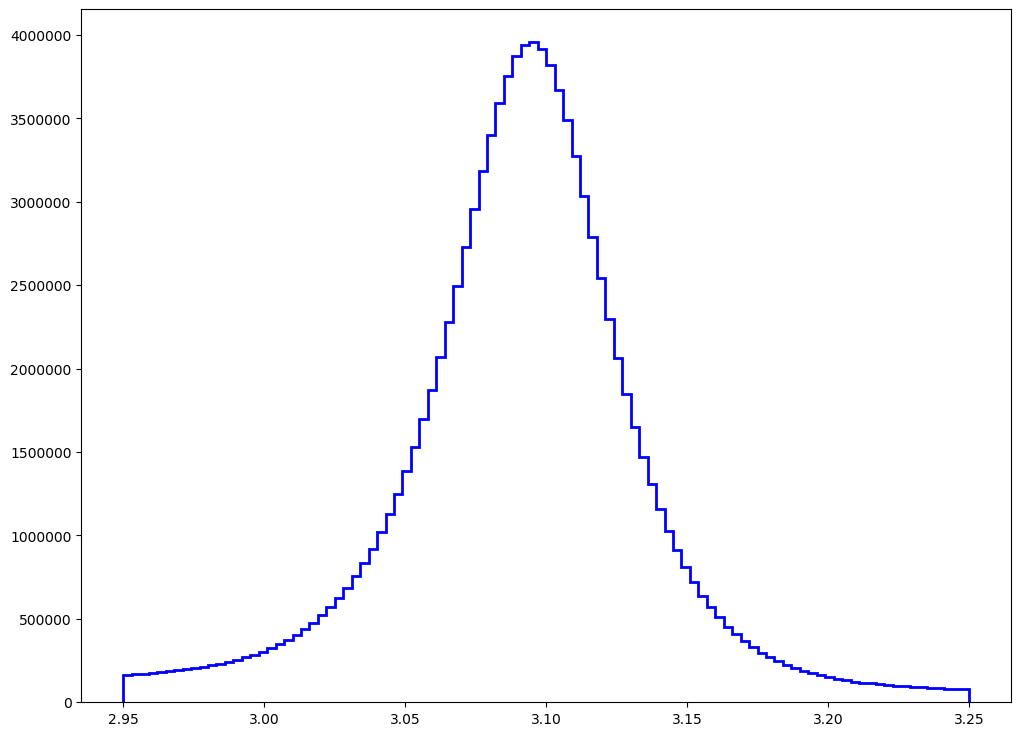

In [65]:
plt.figure(figsize=(12,9))
plt.hist(tree["dimuon_m"],bins=100,histtype="step",color="blue",lw=2);

Let's select the trigger we want to monitor.

In [47]:
allDimuon = tree["HLT_Dimuon25_Jpsi"].astype(float)>0.0

The $p_T$ cut at $25 \text{GeV}$ is clearly visible.

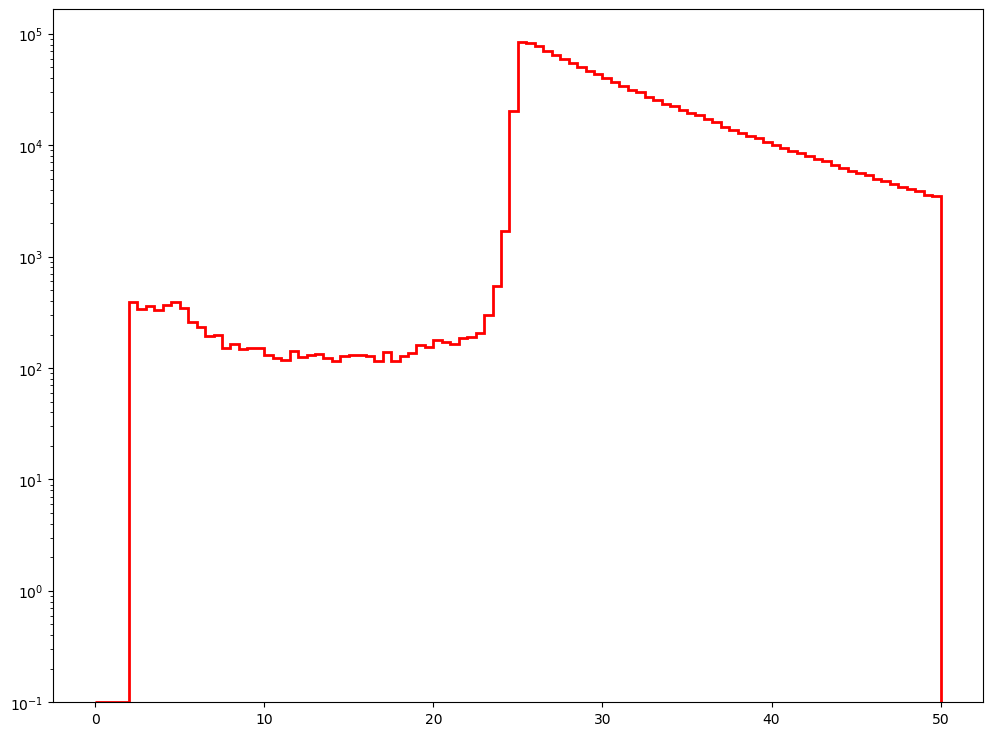

In [48]:
plt.figure(figsize=(12,9))
plt.hist(tree[allDimuon]["dimuon_pt"],bins=100,range=(0.0,50.0),log=True,histtype="step",color="red",lw=2);

In [36]:
tree.trigger.value_counts()

2.0    2448568
4.0    1137404
6.0     164322
Name: trigger, dtype: int64

This is a double check just to drop some duplicate $J/\psi$ (just to be safe)

In [61]:
tree = tree.drop_duplicates(subset=["event","run","lumi","dimuon_m","dimuon_pt"]).reset_index()

And now let's count the numer of $J/\psi$ per run.

In [50]:
counts_df = tree[allDimuon][RUN].value_counts().astype(float)
counts_df = pd.DataFrame(np.array([counts_df.index.astype(int),counts_df.values]).transpose(1,0),columns=[RUN,"counts"])
counts_df = counts_df[counts_df[RUN]>1]
counts_df.head()

,run,counts
0,315420.0,147151.0
1,315322.0,102257.0
2,316995.0,88564.0
3,316766.0,83710.0
4,315357.0,81902.0


This is the json from the bril/lumi tool.

In [52]:
runs = pd.read_csv(path+"/2018_runs",delimiter=",")
runs[RUN] = runs["run:fill"].apply(runfill)
runs["fill"] = runs["run:fill"].apply(fillrun)
runs = runs.drop(["run:fill"],axis=1)
runs.head()

,time,nls,ncms,delivered,recorded,run,fill
0,04/26/18 21:09:40,90,90,8.244874e+06,7.875652e+06,315257.0,6615.0
1,04/26/18 21:54:51,172,172,1.410498e+07,1.374204e+07,315259.0,6615.0
2,04/27/18 02:45:32,230,230,4.070611e+07,3.901323e+07,315264.0,6616.0
3,04/27/18 04:20:05,55,55,9.150117e+06,6.336633e+06,315265.0,6616.0
4,04/27/18 04:59:11,244,244,3.745539e+07,3.640150e+07,315267.0,6616.0


Let's then merge the two datasets (the $J/psi one and the luminosity one) on the run number.

In [53]:
runs = pd.merge(counts_df, runs, on=RUN)
runs["ratio"] = runs["counts"]*1000.0/runs["recorded"] # from mb to µb

In [54]:
min_run = tree[RUN].min()
max_run = tree[RUN].max()

Text(0.5, 1.0, 'Candidates Count')

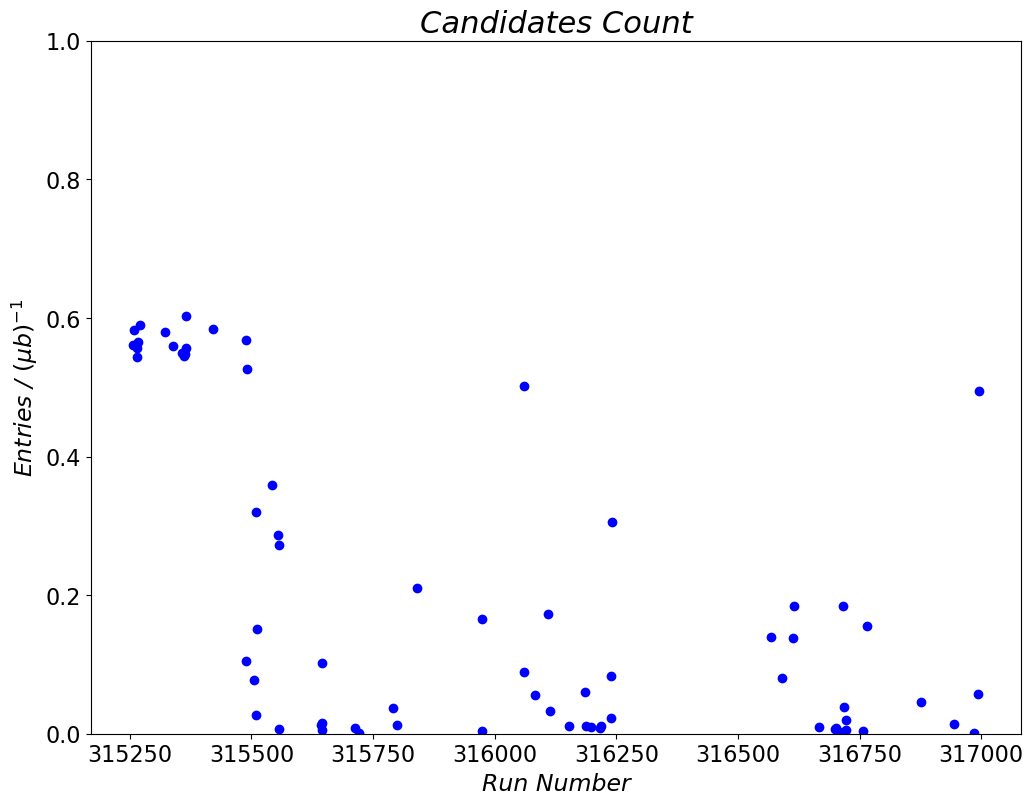

In [56]:
xnames = runs[RUN]

plt.figure(figsize=(12,9))
ax = plt.gca()

plt.plot(xnames,runs["ratio"].values,"o",color="blue");
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.xlabel("Run Number",fontsize=17,fontstyle="italic")
plt.ylabel("Entries / $(µb)^{-1}$",fontsize=17,fontstyle="italic")
plt.ylim(0,1.0)

plt.title("Candidates Count",fontsize=22,fontstyle="italic")